<a href="https://colab.research.google.com/github/SavkinEgor/MADE_ML_Speach/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [ ]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [ ]:
# Функция отрисовки аудио сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()



In [ ]:
# Для выполнения задания нам понадобится датасет yes/no. 
# Про датасет можно почитать тут https://www.openslr.org/1/

# Скачаем его
![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
!tar -xvzf waves_yesno.tar.gz

# P.S если у вас Windows, или по каким-либо еще причинам данные не скачались, 
# то их можно скачать руками отсюда: https://www.openslr.org/1/

--2021-03-12 08:51:46--  https://www.openslr.org/resources/1/waves_yesno.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703754 (4.5M) [application/x-gzip]
Saving to: ‘waves_yesno.tar.gz’

waves_yesno.tar.gz  100%[===================>]   4.49M  4.01MB/s    in 1.1s    

2021-03-12 08:51:48 (4.01 MB/s) - ‘waves_yesno.tar.gz’ saved [4703754/4703754]

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/0_0_1_1_1_0_0_0.wav
waves_yesno/0_1_1_1_1_1_1_1.wav
waves_yesno/0_1_0_1_1_1_0_0.wav
waves_yesno/1_0_1_1_1_0_1_0.wav
waves_yesno/1_0_0_1_0_1_1_1.wav
waves_yesno/0_0_1_0_1_0_0_0.wav
waves_yesno/0_1_0_1_1_0_1_0.wav
waves_yesno/0_0_1_1_0_1_1_0.wav
waves_yesno/1_0_0_0_1_0_0_1.wav
waves_yesno/1_1_0_1_1_1_1_0.wav
waves_yesno/0_0_1_1_1_1_0_0.wav


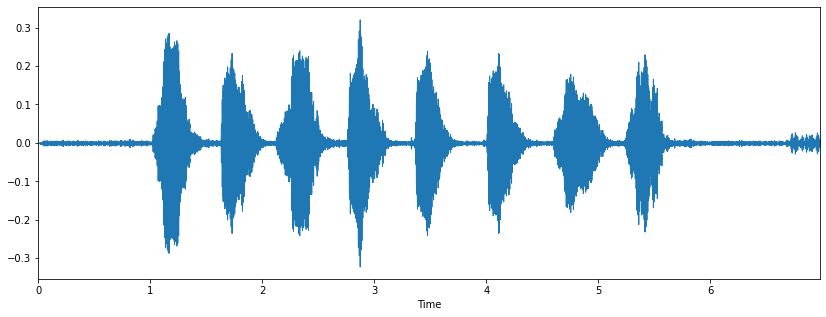

In [ ]:
# Загрузим один из файлов
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

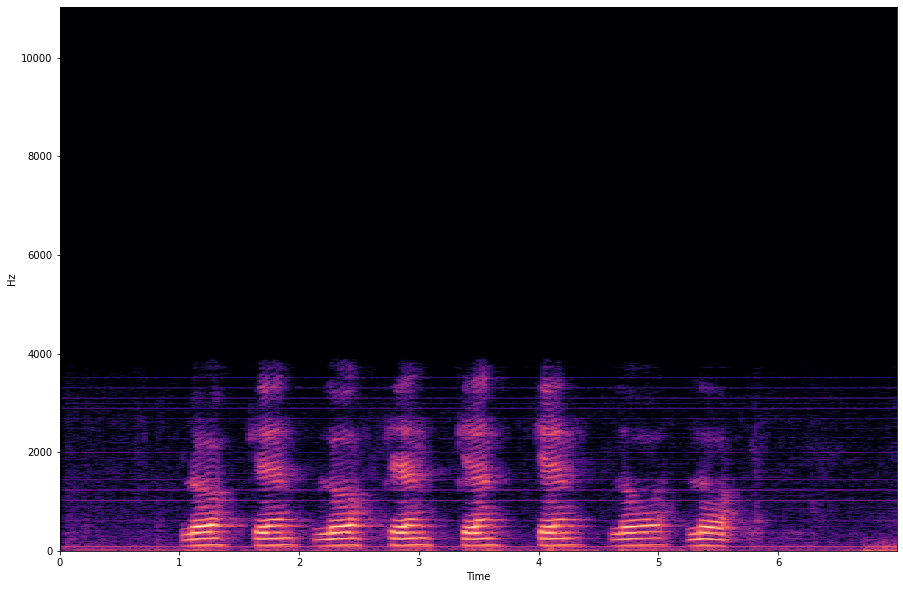

In [ ]:
# Построим спектрограмму загруженной вавки
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

1. -
2. -

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [ ]:
def mel(spec):
    #spec - stft spectrogram
    
    # YOUR CODE HERE
    #
    return 1127 * np.log(1 + spec / 700)
    #
    raise NotImplementedError()

In [ ]:
def mel_to_hz(x_mel):
    return 700 * (np.power(10, x_mel / 2595) - 1)

In [ ]:
x = np.array([1,2,3])
np.allclose(x, mel_to_hz(mel(x)))

True

In [ ]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "

In [ ]:
test_mel()

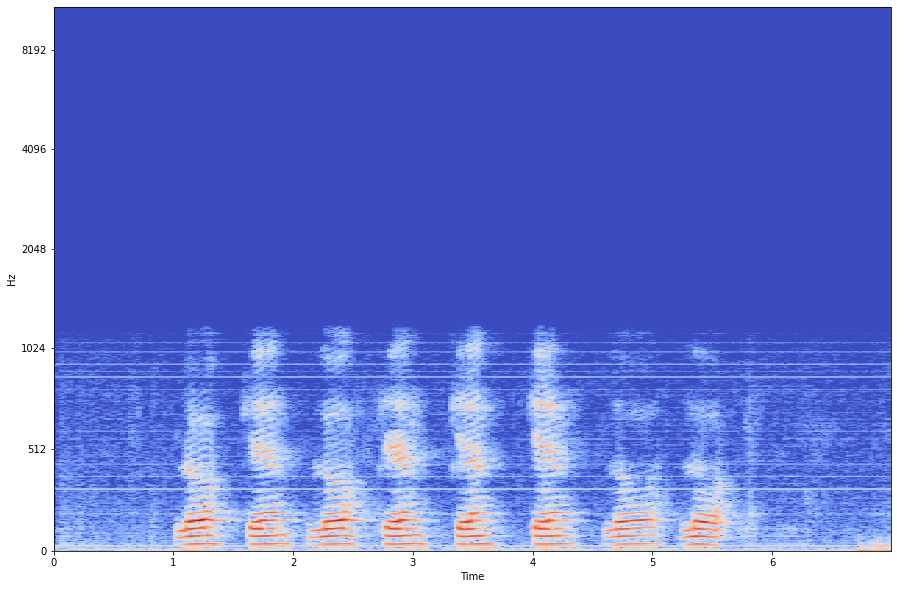

In [ ]:
# Построим спектрограмму загруженной вавки в мел
stft = librosa.stft(wav)
stft_mel = mel(stft)
stft_db = librosa.amplitude_to_db(abs(stft_mel))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='mel')

# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
Реализуйте функцию вычисления fbank. 

In [ ]:
def mel_filters(sr, n_fft, n_mels):
    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]

    # YOUR CODE HERE
    #
    fmin = 0.
    fmax = sr / 2
    #
    # Initialize the weights
    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)))

    # Center freqs of each FFT bin
    fftfreqs = np.linspace(0, sr / 2, 1 + n_fft // 2, endpoint=True)

    # 'Center freqs' of mel bands - uniformly spaced between limits
    mel_f = librosa.mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax)
    # Если делать по формуле - не проходит по точности
    # mel_f = mel_to_hz(np.linspace(mel(fmin), mel(fmax), n_mels + 2))

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i+2] / fdiff[i+1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))
    
    enorm = 2.0 / (mel_f[2:n_mels+2] - mel_f[:n_mels])
    weights *= enorm[:, np.newaxis]

    return weights

    raise NotImplementedError

In [ ]:
(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4))

(array([[0.     , 0.46875, 0.     , 0.     , 0.     ],
        [0.     , 0.15625, 0.3125 , 0.     , 0.     ],
        [0.     , 0.     , 0.3125 , 0.15625, 0.     ],
        [0.     , 0.     , 0.     , 0.46875, 0.     ]]),
 array([[0.     , 0.46875, 0.     , 0.     , 0.     ],
        [0.     , 0.15625, 0.3125 , 0.     , 0.     ],
        [0.     , 0.     , 0.3125 , 0.15625, 0.     ],
        [0.     , 0.     , 0.     , 0.46875, 0.     ]], dtype=float32))

In [ ]:
assert mel_filters(32, 46, 4).shape == (4, 24) and \
    mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4))
assert np.allclose(mel_filters(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40))
print("All ok!")

All ok!


In [ ]:
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]
    
    # # YOUR CODE HERE
    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000

    S = np.abs(librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)) ** 2

    mel_basis = mel_filters(sr, n_fft, n_fbanks)
    
    return np.dot(mel_basis, S)

In [ ]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)
    
    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_fbank(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_fbank(wav, sr) == 0 , "All wav test failed"
print("All ok!")

TEST PASSED
TEST PASSED
All ok!


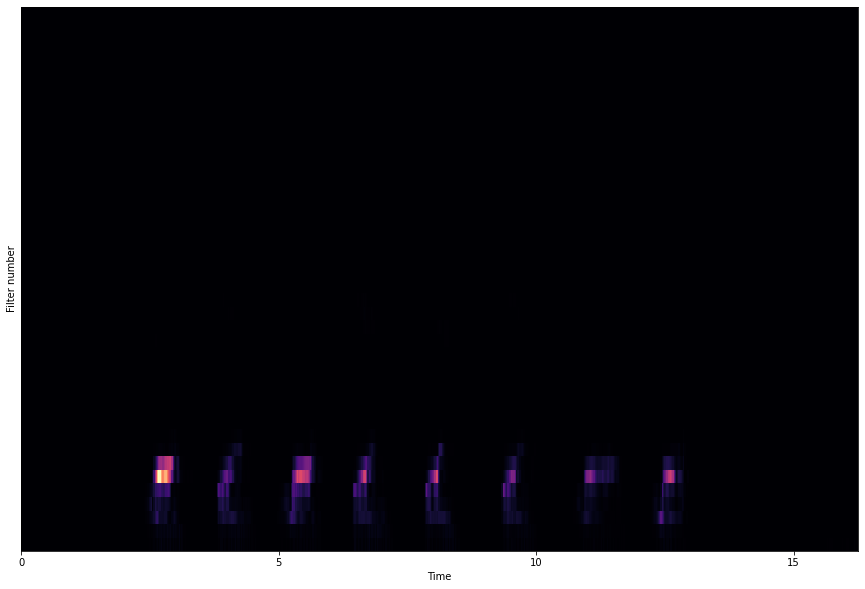

In [ ]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 4 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [ ]:
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_mfcc=13):
      # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    # YOUR CODE HERE
    # S = librosa.power_to_db(get_fbanks(wav, sr=sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=128)) # не проходит по точности...
    # Не представляю как можно выполнить это и предыдущее задание, если не заглядывать в код librosa
    # Некоторые параметры по умолчанию откуда знать?
    # По формулам простым не проходят по точности некоторые функции...
    S = librosa.power_to_db(librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length))
    return scipy.fftpack.dct(S, axis=0, type=2, norm='ortho')[:n_mfcc]
    #
    raise NotImplementedError()

In [ ]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
    if not np.allclose(mfcc_lib, mfcc):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_mfcc(wav, sr) == 0 , "All wav test failed"
print("All ok!")

TEST PASSED
TEST PASSED
All ok!


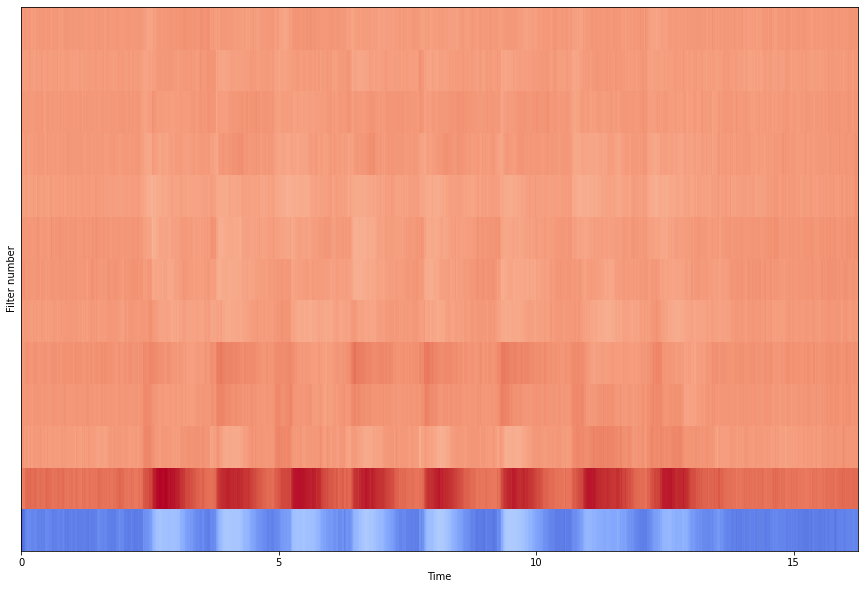

In [ ]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [ ]:
def load_yn_dataset(directory):
    X, labels = [], []
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

Отделим 20% для теста

In [ ]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *5 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре или нет.
Реализуйте простой VAD.
Настройте VAD, чтобы хорошо определялись границы слов.

In [ ]:
np.quantile(np.abs(X_train[0]), 0.05)

0.00040883102046791465

In [ ]:
# YOUR CODE HERE

# train_VA = # np.ndarray. 1 - Voice, 0 - silence
# test_VA = # np.ndarray. 1 - Voice, 0 - silence
        
#
    

In [ ]:
def test_VAD(VA, Y):
    def check_diff(diff, num_words):
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            print("Wrong number of words. Each audio contains 8 words")
            return -2
        return 0
    
    for i, (va, y) in enumerate(zip(VA, Y)):
        diff = va[1:]  - va[:-1]
        assert check_diff(diff, len(y)) == 0, f"Bad {i} example"

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test)

# Задание *6 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки слов выделеных слов. Или любым другим удобным для вас способом. 